# Tutorial: Alignment with Infrared (for Developers)


We demonstrate LicoRNA-style alignment in Infrared. The code models and solves a variant of the pairwise RNA structure alignment where a potentially crossing secondary structure is given for the first sequence; it is aligned against the 'plain' second sequence. The alignment score captures correlated matches to the ends of base pairs. The model furthermore supports affine gap cost.

*Definition:* RNA structure alignment 'CROSSING/PLAIN'. Given two sequences and a crossing structure of the first one, find the best pairwise alignment subject to the alignment score, consisting of
* position dependent base similarity
* affine gap cost
* similarity of base pair matches, depending on the base pair and the positions in the second sequence that are matched to the base pair ends


*Note*: The standard CTE evaluation by Infrared does not handle "smooth bags" optimally. Since we compute banded alignments, this multiplies run-time by the banding width.

In [1]:
import infrared as ir
import infrared.rna as rna
import treedecomp

import math
import time

## Problem input and test instances

We define several test instances. Each one is specified by two sequences $a$ and $b$ and a structure $s$ for $a$. The structure can be crossing! It is specified in extended dot-bracket notation.

In [38]:
## a small test instance
ex_small = dict(\
    a = "ACGGUC",
    s = "(([))]",
    b = "UUGCAG")

## another small test instance
ex_small2 = dict(\
    a = "AAAACAUAG",
    s = "..(.[.).]",
    b = "AGAUACUAU")

ex_small3 = dict(\
    a = "AAAACAGAUAGAC",
    s = "..(.[.{.).].}",
    b = "AGAUACAGAAAC")

ex_simple_crossing = dict(\
    a = "CGCCAAUACAAUAGGGUUUAU",
    s = "(.((.[[[.....)))..]]]",
    b = "GCGCAAACAAGCGAAUUUUAA")

ex_intermediate = dict(\
    a = "CGCCAAUAAUAGGGUUUAU",
    s = "(.(([[.[{{.)))]]]}}",
    b = "GCGCAAACAAGCGAAUUUUU")

# Licorna example RF01099 ( Treewidth 3 / 7 )
ex_licorna_RF01099 = dict(\
    a = "UUCCAGGACAUACUGCUGAGGAUGUCAAAAAUGCAGUUGGAGUCCUCA",
    s = ".<<<<<...........((((((.............>>>>>)))))).",
    b = "UUCCAGGACAUACUGAUGAGAAUGUCAAAGAUGCAGUUGGGGUCCUCA")

# Licorna example RF01831 ( Treewidth 4 / 9 )
ex_licorna_RF01831 = dict(\
    a = "UCAGAGUAGAAAACGAUGCGUUAAGUGUCCAGCAGACGGGGAGUUGCUGCCGGAACGAAAAGCAAAGCUUGCGGUAUCGUUUUCGCAUCCCGCUGA",
    s = "<<<<....<<<<<<<<<<<.....<<.<<<.<<<<...(((.((..>>>>.>>>>>...<<<<...>>>>...>>>>>>>>>>>)).)))..>>>>",
    b = "GCAGAGUAGACACAUGUGCGUUAAGUGCCGGAUGAACAGGGAGUUGUCACCCGGACGAAAAGAAAAUCUUGCGGUACAUGAGUCGCAUCCCGCUGC")

# Licorna example RF01786 (challenging b/c this requires large c)
ex_licorna_RF01786 = dict(\
    #3Q3Z.seq vs target 2
    a = "CCCCGGAAACAAAAACGAAUGUGAAUGGGUUGGGCAUGGGCACUAGACUCAUUUUGUGUUGCAAGUGCACCCGA",
    s = "............((((.....((((((((((.....<[[[[[[[.))))))))))..)))...]]]]]>.]].)",
    b = "ACUGCAAUGGGUGUGAUGAAGUCCGGACAGUAAUGUGGGCACUUAGUCCGGACCGAGCAAGUAGUGCAACCGACCAGAUGCAAA")

## Specialized tree decomposition

Different tree decomopositions of the same tree width can result in practically relevant performance differences of Infrared's evaluation. This is even true when all variables have the same domain size, but it becomes even more critical, when variables have strongly different sizes (e.g. some variables are boolean, while the size of others is linear in the problem input).

NXOptDspTDFactory implements a heuristic form of tree decomposition that chooses the td with minimal product of domain sizes from a series of tree decompositions, which are heuristically produced to minimize tree width.
In the case of equal domain sizes, the objective minimal tree width and minimal sum over domain size product is an adequate estimator of the run-time of the evaluation by CTE.
In the case of strongly different domain sizes, there is generally no guarantee that the optimal sum of domain size products is achieved for minimal treewidth. (In practice, the proposed strategy is still preferable over standard tree decomposition.)

We try to adapt the search time to the problem complexity; in order to safe over-all computation time, it pays off to optimize harder for harder instances.

This code should be generalized and moved into the tree decomposition module.

In [3]:
class NXOptDspTDFactory(treedecomp.NXTreeDecompositionFactory):
    """
    Treedecomp factory that optimizes the sum of domain size products over 
    tree decompositions generated by NXTreeDecompositionFactory
    """
    
    def __init__(self, model, verbose = False):
        super().__init__(iterations=1, adaptive=None)

        self._model = model
        self._optdsp_verbose = verbose
        
    def create(self, size, dependencies):        
        ## optimize tree decomposition --- this optimization should be moved to TD Factory entirely
        best_domsizeprod = None

        i=0
        while True:
            i+=1
            
            td = super().create(size, dependencies)
            tw = td.treewidth()
            
            bags = td.get_bags()

            import math
            domsizeprod = sum(math.prod( self._model.domains[x].size() for x in bag ) for bag in bags)

            if best_domsizeprod==None or domsizeprod < best_domsizeprod:
                best_domsizeprod = domsizeprod
                best_td = td

                ## some magic formula to try harder for harder instances, not super-optimized
                thresh = 33 * 1.5**(domsizeprod/3e8)
                #print('Thresh',thresh)
            if i > thresh:
                break

        if self._optdsp_verbose:
            print( "After iteration",i,"Treewidth:",tw,end=", ")
            #print( "Effective Treewidth:", max(len( [ x for x in b if x <= len(a)+1 ]) for b in bags) -1, end=", " )
            print( f"Domain size product sum: {best_domsizeprod:.2e}" )

        return best_td

class ConstTDFactory:
    """@brief TD factory returning a constant TD
    Allows to pass and reuse an already computed TD 
    """
    def __init__(self,td):
        self._td = td
    def create(self,_size,_dependencies):
        return self._td

## Showing information on the tree decomposition

Code to display 'internal' information on the generated td for demonstration purposes.

Note: the function performs a Monkey patch on TreeDecomposition. This code should be generalized and moved to treedecomp

In [4]:
def show_td_info(engine,width=600):
    """
    Show information on tree decomposition
    @param engine An Infrared engine (Optimizer, Sampler, ...)
    @param width width of td plot
    
    Draws the tree decomposition and prints some information (tree width, bag sizes...)
    """
    
    td = engine.td
    model=engine._model

    index_to_namedvar = dict()

    varnames = list(model._domains.keys())

    offset = 0
    for name in varnames:
        num = model.num_named_variables(name)
        print(name, num)

        for idx in range(num):
            index_to_namedvar[offset+idx] = f"{name}{idx}"
        offset += num

    
    # Monkey patch TreeDecomposition.writeTD
    from treedecomp import TreeDecomposition

    # @brief Write tree decomposition in dot format
    # @param out output file handle
    def writeTD(self, out):
        from math import sqrt, ceil

        def baglabel(bag):
            if len(bag) == 0:
                return ""

            lwidth = ceil(sqrt(len(bag)))
            lnum = ceil(len(bag) / lwidth)
            xs = [index_to_namedvar[i] for i in sorted(bag)]
            lines = list()
            for i in range(0, lnum):
                lines.append(" ".join(xs[i*lwidth:(i+1)*lwidth]))
            return "\\n".join(lines)

        out.write("digraph G {\n\n")

        for bagid, bag in enumerate(self._bags):
            label = baglabel(bag)
            out.write("\tbag{} [label=\"{}\"]\n".format(bagid+1, label))

        out.write("\n\n")

        for (x, y) in self._edges:
            edgelabel = " ".join(
                [index_to_namedvar[x] for x in self.diff_set(self._bags[x], self._bags[y])])
            out.write(
                "\tbag{} -> bag{}  [label=\"{}\"]\n".format(x+1, y+1,
                                                            edgelabel))

        out.write("\n}\n")

    orig_writeTD = TreeDecomposition.writeTD

    TreeDecomposition.writeTD = writeTD
    
    print("tree width =", td.treewidth())
    
    bags_w_names = [[ index_to_namedvar[x] for x in bag] for bag in td.bags]
    
    print("bags =", bags_w_names)
    print("edges =", td.edges)
    
    tmpfile="tmp_out.png"
    engine.plot_td(tmpfile,'png')
    
    TreeDecomposition.writeTD = orig_writeTD
    
    from IPython.display import Image
    return Image(filename=tmpfile,width=width)

## Represent alignments as objects

As preparation, defining classes for representing alignments

In [5]:
def is_compl(x,y):
    return (x+y) in ["AU","CG","GC","GU","UA", "UG"]

class Alignment:
    def __init__( self, assignment, a, s, b ):
        self._a = a
        self._s = s
        self._b = b
        self._assignment = assignment
        self._values = assignment.values()
        self._edges = self._values_to_edges(self.values)
    
    @property
    def values(self):
        return self._values

    @property
    def edges(self):
        return self._edges

    @staticmethod 
    def _values_to_edges(values):
        edges = list()
        for x,x1 in zip(values,values[1:]):
            edges.append(x1-1 if x<x1 else -1)
        edges = edges[:-1]
        return (edges)
    
    def _alignment_strings(self):
        s = list()
        b = list()
        a = list()
        t = list()
         
        for i,(x,x1) in enumerate(zip(self._values,self._values[1:])):
            if x<x1:
                for j in range(x,x1-1):
                    a.append('-')
                    s.append('-')
                    b.append(self._b[j])
                if i<len(self._a):
                    a.append(self._a[i])
                    s.append(self._s[i])
                    b.append(self._b[x1-1])
            if x==x1:
                if i<len(self._a):
                    a.append(self._a[i])
                    s.append(self._s[i])
                    b.append('-')

        t = [ '-' if x=='-' else '.' for x in b ]
        s = "".join(s)
        for (i,j) in rna.parse(s):
            if is_compl(b[i],b[j]):
                t[i]=s[i]
                t[j]=s[j]
                    
        return [ s, "".join(a), "".join(b), "".join(t)]
    
    def __str__(self):
        alignment = self._alignment_strings()
        return "\n".join(alignment)

... and define the scoring scheme in a class

In [6]:
class AliScore():
    """Define the alignment score"""
    
    def __init__(self, a, b):
        """
        Construct with a pair of sequences
        @param a first sequence string
        @param b second sequence string
        """
        self._a = a
        self._b = b
    def beta( self ):
        """Gap opening cost"""
        return -1
    def gamma( self, k = 1 ):
        """
        Gap cost
        @param k gap length
        """
        return -1 + self.beta()*k
    def sigma( self, x, y ):
        """
        Base similarity
        @param x 1-based position in first sequence
        @param y 1-based position in second sequence
        """
        return 2 if self._a[x-1]==self._b[y-1] else 0
    def psi( self, x, y ):
        """
        Base pair similarity
        @param x match of left end, 1-based position in second sequence
        @param y match of right end, 1-based position in second sequence
        """        
        return 10 if is_compl(self._b[x-1],self._b[y-1]) else 0

## Expressing the alignment problem as Infrared model 

We define specialized constraints and functions to define the alignment model for a specific instance.
Constraints are used to express order on the X variables. The functions are used to define the alignment score.

Note that the constraints and functions use the function var to translate named variables to internal indices. In this way,
we can distinguish variables like X_0,...n+1 and Y_0,...n+1 and use this naming scheme in the code.

In [7]:
# express order and equality on variables
ir.def_constraint_class( 'LeqConstraint', lambda i,var: var([('X',i-1),('X',i)]),
                      lambda x1,x: x1<=x )
ir.def_constraint_class( 'EqConstraint', lambda thevar,c,var: var([thevar]), lambda x,c: x==c )

# relate variables X and Y in the model
ir.def_constraint_class( 'XYRelation', lambda i,var: var([('X',i-1),('X',i),('Y',i)]),
                      lambda x1,x,y: (x1<x and y==1) or (x1==x and y==0) )

# restrict domain sizes due to banding (superseeded by direct domain restriction; only left for demonstration)
ir.def_constraint_class( 'BandingConstraint', lambda i,c,n,m,var: var([('X',i)]),
                      lambda x,i,c,n,m: abs(x-i*m/n) <= c )

# similarity of positions in the two sequences.
ir.def_function_class( 'SigmaFunction', lambda i,score,var: var([ ('X',i), ('Y',i) ]),
                     lambda x,y,i,score: score.sigma(i,x) if y==1 else 0 )

# insertion of bases
ir.def_function_class( 'InsertFunction', lambda i,score,var: var([('X',i-1),('X',i)]),
                    lambda x1,x,score: score.gamma(x-x1-1) if x1+1<x else 0 )

# deletion of bases
ir.def_function_class( 'DeleteFunction', lambda i,score,var: var([('Y',i-1),('Y',i)]),
                    lambda y1,y,score: ( score.beta() if y1==0 else score.gamma(1) ) if y==0 else 0 )

# matches at base pairs
ir.def_function_class( 'PhiFunction', lambda i,j,score,var: var([('X',i),('Y',i),('X',j),('Y',j)]),
                    lambda xi,yi,xj,yj,score: score.psi(xi,xj) if yi==1 and yj==1 else 0 )

### Setting up the model

First, we define the concrete problem instance, select control options and heuristic parameters.

In [39]:
## control whether to use banding by direct domain restriction (or constraint). The former is way more efficient.
DOMAIN_BANDING = True
#DOMAIN_BANDING = False

#ex = ex_small2
ex = ex_intermediate
#ex = ex_licorna_RF01099
# ex = ex_licorna_RF01831

# constant offset for banding
c=4

print(ex['s'])
print(ex['a'], len(ex['a']))
print(ex['b'], len(ex['b']))

(.(([[.[{{.)))]]]}}
CGCCAAUAAUAGGGUUUAU 19
GCGCAAACAAGCGAAUUUUU 20


In [40]:
# This is done in LicoRNA
#c = max(c,abs(len(a)-len(b))) # one doesn't have to do this

n = len(ex['a'])
m = len(ex['b'])

bps = rna.parse(ex['s'])
score = AliScore( ex['a'], ex['b'] )


model = ir.Model()

# X_i's encode alignments, such that 
#  * X_i=j for alignment edges (i,j) (1-based pos indices!) and
#  * X_i==X_i-1 if X_i is deleted
#  * X_0 = 0
#  * X_n+1=m+1
model.add_variables( 1, (0,0), name = 'X' )
model.add_variables( n, m+1, name = 'X' )
model.add_variables( 1, (m+1,m+1), name = 'X' )

# Y_i is 1 iff i is matched
model.add_variables( 1, (1,1), name = 'Y' )
model.add_variables( n, 2, name = 'Y' )

var = lambda vs: model.idx(vs)

model.add_constraints( LeqConstraint( i, var ) for i in range(1,n+2) )
model.add_constraints( XYRelation( i, var ) for i in range(1,n+1) )

#model.add_constraints( EqConstraint( ('X',n+1), m+1, var ) )
#model.add_constraints( EqConstraint( ('Y',0), 1, var ) )

model.restrict_domains( ('Y',1), (1,1) )


if DOMAIN_BANDING:
    for i in range(1,n+1):
        lb = max(1, math.floor(i*m/n) - c)
        ub = min(m, math.ceil(i*m/n) + c )
        model.restrict_domains( ('X',i), (lb,ub) )    
else:
    model.add_constraints( BandingConstraint( i, c, n, m, var ) for i in range(1,n+1) )

model.add_functions( [ SigmaFunction( i, score, var )
                       for i in range( 1, n+1 ) ], group = 'sigma' )
model.add_functions( [ InsertFunction( i, score, var )
                       for i in range( 1, n+2 ) ], group = 'indels' )
model.add_functions( [ DeleteFunction( i, score, var )
                       for i in range( 1, n+1 ) ], group = 'indels')

model.add_functions( [ PhiFunction(i+1, j+1, score, var) for (i,j) in bps ], group = 'phi' )

## set weights to 1
w = 1
model.set_feature_weight(w,"sigma")
model.set_feature_weight(w,"indels")
model.set_feature_weight(w,"phi")

### Performing optimization to compute an optimal alignment

After iteration 34 Treewidth: 9, Domain size product sum: 4.99e+06
Banding: 4
t = 0.2s
Optimal alignment score: 91
Score 91 = 24 + -13 + 80
-(.(([[.[-{{.)))--]]]}}
-CGCCAAUA-AUAGGG--UUUAU
GC-GCAA-ACAA-GCGAAUUUUU
.(-(([[-[.{{-)))..]]]}}

t = 0.7s


----- TD Info -----
X 21
Y 20
tree width = 9
bags = [['X15', 'Y8', 'X8', 'Y17', 'Y15', 'X5', 'Y5', 'Y12', 'X17', 'X12'], ['Y8', 'X8', 'Y17', 'Y12', 'Y10', 'X17', 'X12'], ['Y8', 'X8', 'Y17', 'Y10', 'X10', 'Y12', 'X17', 'X12'], ['X15', 'Y8', 'X8', 'Y17', 'Y15', 'X5', 'Y5', 'X16', 'X17'], ['X15', 'Y8', 'X8', 'Y17', 'Y16', 'Y15', 'X5', 'Y5', 'X16'], ['Y8', 'Y5', 'X8', 'Y16', 'X16', 'Y6', 'X5'], ['Y8', 'X8', 'Y16', 'X16', 'Y6', 'X5', 'X6'], ['Y8', 'X10', 'X8', 'Y17', 'Y18', 'Y10', 'X17'], ['Y8', 'X10', 'X8', 'Y18', 'X18', 'Y10', 'X17'], ['Y8', 'X10', 'X8', 'X18', 'Y18', 'Y10', 'Y9'], ['X10', 'X9', 'X8', 'X18', 'Y18', 'Y10', 'Y9'], ['X15', 'Y5', 'X4', 'Y12', 'Y15', 'X5', 'X12'], ['X15', 'Y4', 'Y5', 'X4', 'Y12', 'Y15', 'X12'], ['X15', 'Y4', 'X4', 'Y

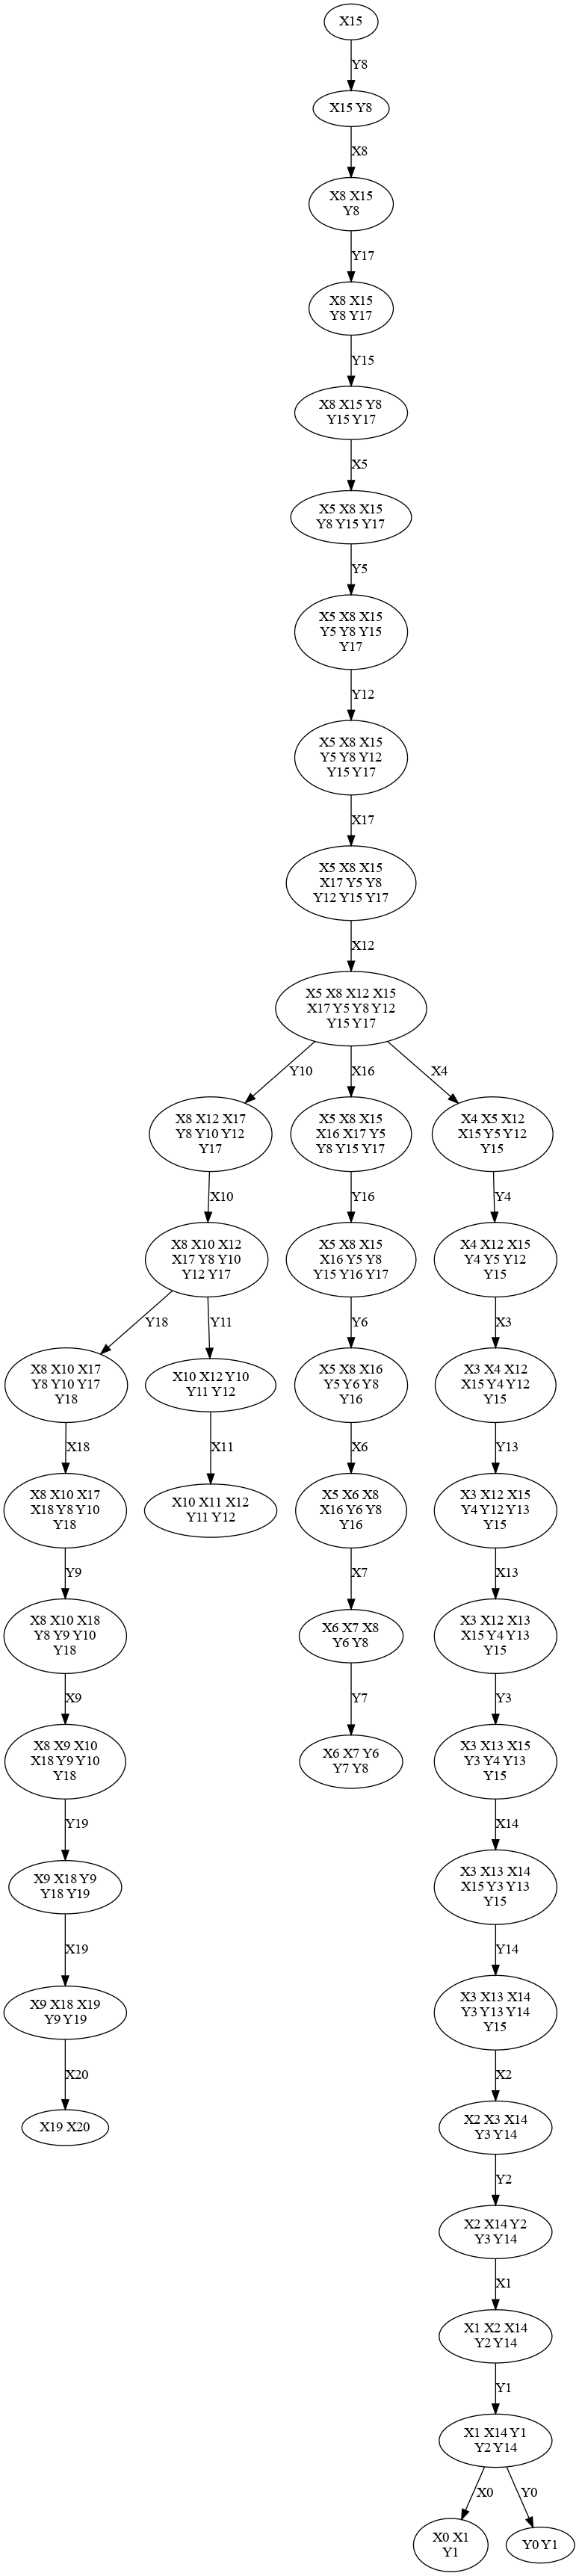

In [41]:
td_factory = NXOptDspTDFactory(model, verbose=True)

### Before sampling, determine the optimal score 
alioptimizer = ir.Optimizer( model, td_factory )

t0 = time.time()

alioptimizer.treewidth()

print("Banding:", c)

alioptimizer.plot_td("treedecomp.pdf")
      
print(f"t = {time.time()-t0:.1f}s")

best_score = round( alioptimizer.evaluate() )
print(f"Optimal alignment score: {best_score}")

best_alignment = alioptimizer.optimize()

def report_alignment(alignment):
    sigma = model.eval_feature( alignment, 'sigma' )
    indels = model.eval_feature( alignment, 'indels' )
    phi = model.eval_feature( alignment, 'phi' )
    print(f"Score {sigma + indels + phi} = {sigma} + {indels} + {phi}" )
    print( Alignment( alignment, ex['a'], ex['s'], ex['b'] ) )
    print()
    
report_alignment(best_alignment)
print(f"t = {time.time()-t0:.1f}s")


print("")
print("")
print("----- TD Info -----")
show_td_info(alioptimizer,width=550)

### Sampling alignments

In [11]:
## set weights (='inverse temperature')
w = 0.9
model.set_feature_weight(w,"sigma")
model.set_feature_weight(w,"indels")
model.set_feature_weight(w,"phi")

# number of samples
K=5

# sampler for the model
alisampler = ir.BoltzmannSampler( model, ConstTDFactory(alioptimizer.td) )

alisampler.setup_engine()
pf = alisampler.ct.evaluate()

print(f"Partition function = {pf:.2e}")
popt = math.exp(w*best_score)/pf
print(f"Probability of optimum = { popt :.2f}")
print(f"Pr to see optimum in {K} samples = { 1-(1-popt)**K :.2f}")

print(f"t = {time.time()-t0:.1f}s")

## and print samples
for _ in range(K):
    sample = alisampler.sample()
    print()
    report_alignment(sample)
    
print()
print(f"t = {time.time()-t0:.1f}s")

import os, psutil
process = psutil.Process(os.getpid())
print(f'RSS {process.memory_info().rss/1024/1024:.1f} Mb')  # in bytes

Partition function = 9.99e+10
Probability of optimum = 0.88
Pr to see optimum in 5 samples = 1.00
t = 0.4s

Score 28 = 8 + 0 + 20
..(.[.).]
AAAACAUAG
AGAUACUAU
..(.[.).]


Score 28 = 8 + 0 + 20
..(.[.).]
AAAACAUAG
AGAUACUAU
..(.[.).]


Score 24 = 8 + -4 + 20
..(.-[.).]
AAAA-CAUAG
AGA-UACUAU
..(-.[.).]


Score 28 = 8 + 0 + 20
..(.[.).]
AAAACAUAG
AGAUACUAU
..(.[.).]


Score 28 = 8 + 0 + 20
..(.[.).]
AAAACAUAG
AGAUACUAU
..(.[.).]


t = 0.4s
RSS 98.8 Mb
